# Multiple Linear Regression

## Introduction

Back in the day when I was in 10th grade, I didn't know that much math but I was really interested in machine learning. So I just focused on the APIs and the general intuition behind the algorithms. 

This year however, I graduated from the high school and know a little bit more math (especially I've learned some calculus) so I've decided to learn all the algorithms from scratch with their math backgrounds. And this is my first step :)

I'm looking forward to see your suggestions and improvements :)

## Loading Data

Dataset is shared by Nikhil Narayan, thanks for the contribution. [Kaggle dataset link](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy


In [2]:
data = pd.read_csv("Student_Performance.csv")
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


* Feature "Extracurricular Activities" is a boolean feature (it only consists of Yes or No) but it's given in strings, we should convert them to integers.

In [4]:
boolean_extactivites = []
for x in data["Extracurricular Activities"]:
    if x=="Yes":
        boolean_extactivites.append(1)
    elif x=="No":
        boolean_extactivites.append(0)
    else:
        raise Exception("There's something else than yes or no!")
        

In [5]:
data["Extracurricular Activities"] = boolean_extactivites
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [6]:
y_train = data["Performance Index"].to_numpy()
X_train = data.drop(axis="columns",labels="Performance Index").to_numpy().astype("float64")

print("Shape of y_train",y_train.shape)
print("Shape of x_train",X_train.shape)

Shape of y_train (10000,)
Shape of x_train (10000, 5)


## Mean Normalization

When we have features that have different ranges (say one feature is ranged between -3 to 3 and the other is 100 to 1000) this can cause gradient descent to run **slower**. So if we rescale them using one of the normalization techniques, we can overcome this problem. 

I've used mean normalization technique, which centers the data around 0. Formula for the mean normalization can be written as:

***X_normalized = (X_i - X_mean) / (X_max - X_min)***

In [7]:
def compute_normalization_parameters(x):
    """
    computes the needed parameters to perform a mean normalization (max,min and mean)
    and returns them in a dict 
    """
    x_max = np.max(x)
    x_min = np.min(x)
    x_mean = np.mean(x)
    params = {"max":x_max,"min":x_min,"mean":x_mean}
    return params

In [8]:
test_normalization_parameters = compute_normalization_parameters(data["Previous Scores"])
print(test_normalization_parameters)

{'max': 99, 'min': 40, 'mean': 69.4457}


* If we want to use our trained model later, we need to normalize new inputs as well. So we'll store normalization parameters in a dict.

In [9]:
features_norm_parameters = []
for i in range(X_train.shape[1]):
    parameters_i = compute_normalization_parameters(X_train[:,i])
    features_norm_parameters.append(parameters_i)

print(features_norm_parameters)

[{'max': 9.0, 'min': 1.0, 'mean': 4.9929}, {'max': 99.0, 'min': 40.0, 'mean': 69.4457}, {'max': 1.0, 'min': 0.0, 'mean': 0.4948}, {'max': 9.0, 'min': 4.0, 'mean': 6.5306}, {'max': 9.0, 'min': 0.0, 'mean': 4.5833}]


In [10]:
def mean_normalize(X,normalization_parameters):
    "takes normalization parameters and performs normalization"
    normalized = (X - normalization_parameters["mean"]) / (normalization_parameters["max"] - normalization_parameters["min"])

    return normalized


In [11]:
for i in range(X_train.shape[1]):
    X_train[:,i] = mean_normalize(X_train[:,i],features_norm_parameters[i])

print(X_train[0,:])

[ 0.2508875   0.50092034  0.5052      0.49388    -0.39814444]


## Cost Function
* I've used Mean Squared Error (MSE) cost function, to compute cost. 

In [12]:
def compute_cost(x,y,w,b):
    """
    computes cost using mean squared error formula
    x (ndarray) input values
    y (scalar) target
    w (ndarray),b (scalar) parameters of the model
    
    returns 
    total_cost (scalar)
    """
    
    m = x.shape[0]
    
    f_wb = np.dot(x,w) + b
    
    total_cost = np.sum((f_wb - y) ** 2)
    total_cost = total_cost / (2*m)
    return total_cost
    

In [13]:
# Initializing parameters as zero.
w_init = np.zeros(X_train.shape[1])
b_init = 0.0

w_init.shape

(5,)

In [14]:
compute_cost(X_train,y_train,w_init,b_init)

1709.432

## Computing Gradients

* In order to update parameters, we need gradients of each parameter. Gradients can be derived using derivation rules. 

Derivatives of the weights are computed with the formula: ***dJ/dw_i = 2 * sum((f_wb - y)*x_i)/m***

In [15]:
def compute_gradients(w,b,x,y):
    """
    computes gradients of weights
    args
    w (ndarray (n,)),b (scalar) parameters of the model
    x (ndarray (m,n))input features
    y (ndarray (m,)) targets 
    """
    
    # Number of features
    n = x.shape[1]
    
    #Number of samples
    m = x.shape[0]
    
    dj_dw = np.zeros(n,)
    dj_db = 0.0
    
    # Np array consists of predictions
    f_wb = np.dot(x,w) + b
    
    for i in range(n):
        dj_dw_i = np.sum((f_wb - y) * x[:,i])
        dj_dw_i = dj_dw_i / m
        dj_dw[i] = dj_dw_i
    
    dj_db = np.sum(f_wb - y) / m
    
    return dj_dw,dj_db
    

In [16]:
dj_dw_test, dj_db_test = compute_gradients(w_init,b_init,X_train,y_train)
print(dj_dw_test.shape)
print(dj_dw_test)

(5,)
[-2.32377451 -5.16807299 -0.23556896 -0.31344422 -0.26481935]


## Batch Gradient Descent

Batch gradient descent is the algorithm we use to update the parameters using derivatives of each parameter. The reason we call this "batch" is we use the whole training data to update the parameters once. 

Alpha, as known as learning rate is a number we choose and determines how big each step will be. Choosing large numbers may cause the cost to increase (which is a problem since we want to decrease the cost)

Choosing small numbers may cause the algorithm to run slow, but it will decrease eventually.

In [17]:
def batch_gradient_descent(x,y,w,b,cost_function,gradient_function,alpha,num_iterations):
    """
    performs batch gradient descent
    args
    x (ndarray (m,n)), y (scalar) = input and target
    cost_function function to compute cost
    gradient_function function to compute gradients
    """
    
    # History of the cost function to see if gradient descent converges
    J_history = []
    w_updated = copy.deepcopy(w)
    b_updated = copy.deepcopy(b)
    
    for i in range(num_iterations):
        cost_i = cost_function(x,y,w_updated,b_updated)
        
        
        dj_dw,dj_db = gradient_function(w_updated,b_updated,x,y)
        
        w_updated = w_updated - alpha*dj_dw
        b_updated = b_updated - alpha*dj_db
        
        #print(f"w = {w_updated}")
        #print(f"b = {b_updated}")
        #print(f"dj_dw = {dj_dw}")
        #print(f"dj_db = {dj_db}")
        
        if (i+1)%5 == 0:
            J_history.append(cost_i)
        
        if (i+1)%1000 == 0:
            print(f"Iteration {i+1}: Cost: {cost_i}")
            print("\n")
        
    return w_updated,b_updated,J_history
    

In [18]:
w,b,J_history = batch_gradient_descent(x=X_train,
                                       y=y_train,
                                       w=w_init,
                                       b=b_init,
                                       cost_function=compute_cost,
                                       gradient_function=compute_gradients,
                                       alpha=0.01,
                                       num_iterations=10000
                                      )

Iteration 1000: Cost: 33.40490605058179


Iteration 2000: Cost: 7.510973417691677


Iteration 3000: Cost: 3.02626813779753


Iteration 4000: Cost: 2.24285833416802


Iteration 5000: Cost: 2.1051917315809408


Iteration 6000: Cost: 2.0809002779811285


Iteration 7000: Cost: 2.076601905582224


Iteration 8000: Cost: 2.0758398396189683


Iteration 9000: Cost: 2.0757045536891208


Iteration 10000: Cost: 2.075680515488277




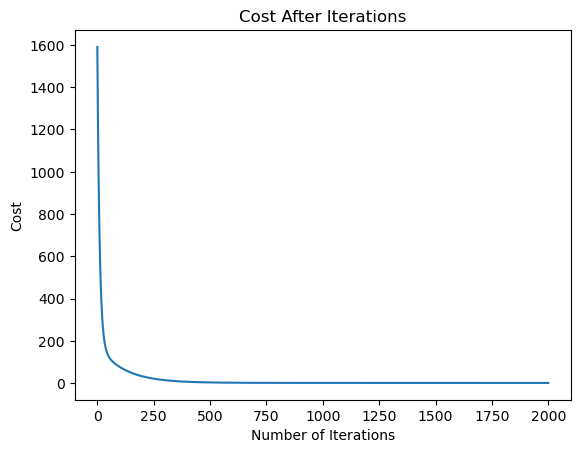

In [19]:
plt.plot(J_history)
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.title("Cost After Iterations")
plt.show()

In [20]:
# IMPORTANT: Do not forget that we have to normalize the data if it's not in the training set.
# The data we predict here is the training set 
y_pred = np.dot(X_train,w) + b


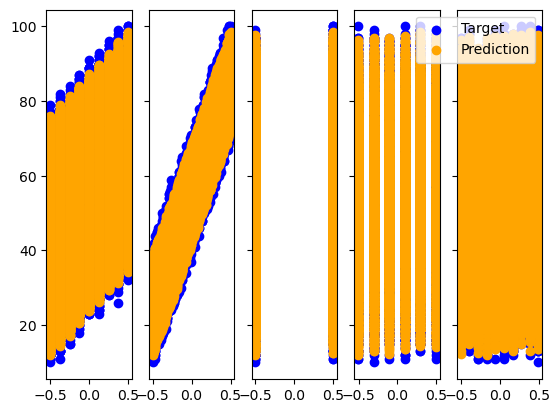

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=5,sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train,color="blue",label="Target")
    ax[i].scatter(X_train[:,i],y_pred,color="orange",label="Prediction")

plt.legend()
plt.show()
